In [2]:
## Uncomment these lines if running as a google colab notebook: 
##! git clone https://github.com/kundajelab/adar_editing
##import os
##os.chdir("adar_editing/xgboost_with_shap/")
##!pip install -e https://github.com/slundberg/shap
##!pip install --upgrade xgboost
##!pip install cufflinks

def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))


In [3]:
%load_ext autoreload
%autoreload 2    
#helper utilities for model training and interpretation 
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap


/users/annashch/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d



## AJUBA xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Computational Dataset</a></li>
    <li><a href=#2>Computational Dataset Feature Subsets</a></li>
 </ol>


## AJUBA Computational features<a name='1'>
<a href=#outline>Home</a>

In [4]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/ajuba_bc_computational.features.csv.cleaned",header=0,sep='\t',index_col=0)

In [5]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [6]:
## prepare data for training with xgboost 
data=format_for_xgboost(data)

(472, 157)


In [7]:
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

{120: 22, 121: 21, 122: 22, 123: 22, 124: 22, 125: 23, 126: 23, 127: 24, 128: 23, 129: 33, 131: 33, 132: 24, 133: 24, 134: 23, 135: 23, 136: 22, 137: 22, 138: 22, 139: 44}


In [8]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [9]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [10]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u3_5prm_cp_interior
site_5prm_cp_bulge:C:G
site_length_hairpin
d3_exist
d2_3prm_cp_interior:A:U
u2_exist
u2_5prm_cp_hairpin
mut_ref_nt:C
site_3prm_cp_bulge:A:U
u3_length_interior_ecs
u1_5prm_cp_interior
u3_length_hairpin
u3_5prm_cp_bulge:G:C
site_next_struct:S
mut_nt:G
d1_struct:B
d3_5prm_cp_hairpin
d1_length_hairpin
d1_struct:S
d2_3prm_cp_interior:U:A
u2_length_bulge
mut_type:mismatch
d2_3prm_cp_interior:C:G
d1_length_interior_ecs
u_hairpin_length
d1_3prm_cp_interior:G:C
d2_exist
site_next_struct:I
u3_3prm_cp_bulge:U:G
d1_5prm_cp_bulge:C:G
u1_length_hairpin
d2_5prm_cp_hairpin
d3_3prm_cp_bulge
u2_3prm_cp_bulge:U:A
mut_ref_nt:G
d1_exist
u2_3prm_cp_bulge:G:U
mut_next_struct:B
u3_struct:S
mut_exist
u3_length_bulge
d1_3prm_cp_bulge:G:U
u1_length_interior_ecs
u3_5prm_cp_hairpin
d1_5prm_cp_hairpin
site_5prm_cp_interior:A:U
u2_5prm_cp_bulge:C:G
u1_3prm_cp_interior
u1_5prm_cp_bulge:U:A
d1_5prm_cp_interior:A:U
u2_length_hairpin
u1_length_interior_es
u2_length_interior_ecs
d1_5prm_cp_interior:G:

In [11]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [12]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [13]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(315, 66)
(315,)
(46, 66)
(46,)
(89, 66)
(89,)


In [14]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [15]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [16]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [17]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	eval-auc:0.660862	eval-mae:0.316747	eval-map:1	eval-aucpr:0.104021	eval-rmse:0.319311	train-auc:0.70996	train-mae:0.325265	train-map:1	train-aucpr:0.131936	train-rmse:0.328117
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-auc:0.660862	eval-mae:0.219799	eval-map:1	eval-aucpr:0.104021	eval-rmse:0.222533	train-auc:0.710601	train-mae:0.228294	train-map:1	train-aucpr:0.138034	train-rmse:0.231034
[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[2]	eval-auc:0.660862	eval-mae:0.150795	eval-map:1	eval-aucpr:0.104021	eval-rmse:0.154355	train-auc:0.714319	train-mae:0.160643

[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-auc:0.715229	eval-mae:0.017564	eval-map:1	eval-aucpr:0.117981	eval-rmse:0.029396	train-auc:0.80524	train-mae:0.004657	train-map:1	train-aucpr:0.183461	train-rmse:0.006935
[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-auc:0.715481	eval-mae:0.017545	eval-map:1	eval-aucpr:0.118006	eval-rmse:0.029389	train-auc:0.805318	train-mae:0.004614	train-map:1	train-aucpr:0.183468	train-rmse:0.006897
[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-auc:0.717853	eval-mae:0.017455	eval-map:1	eval-aucpr:0.118383	eval-rmse:0.029263	train-auc:0.805493	train-mae:0.004529	train-map:1	train-aucpr:0.183491	train-rmse:0.006824
[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extr

[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[54]	eval-auc:0.721209	eval-mae:0.017124	eval-map:1	eval-aucpr:0.116032	eval-rmse:0.029017	train-auc:0.807489	train-mae:0.002802	train-map:1	train-aucpr:0.184538	train-rmse:0.004824
[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[55]	eval-auc:0.721209	eval-mae:0.017124	eval-map:1	eval-aucpr:0.116032	eval-rmse:0.029017	train-auc:0.807489	train-mae:0.002802	train-map:1	train-aucpr:0.184538	train-rmse:0.004824
[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[56]	eval-auc:0.721209	eval-mae:0.017124	eval-map:1	eval-aucpr:0.116032	eval-rmse:0.029017	train-auc:0.807489	train-mae:0.002802	train-map:1	train-aucpr:0.184538	train-rmse:0.004824
[18:16:17] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra n

In [18]:
# save to binary file for faster loading
bst.save_model('ajuba.computational.model')
# save model to text file 
bst.dump_model('ajuba.computational.raw.txt')


In [19]:
## get model predictions on the test split 
test_pred = bst.predict(dtest)

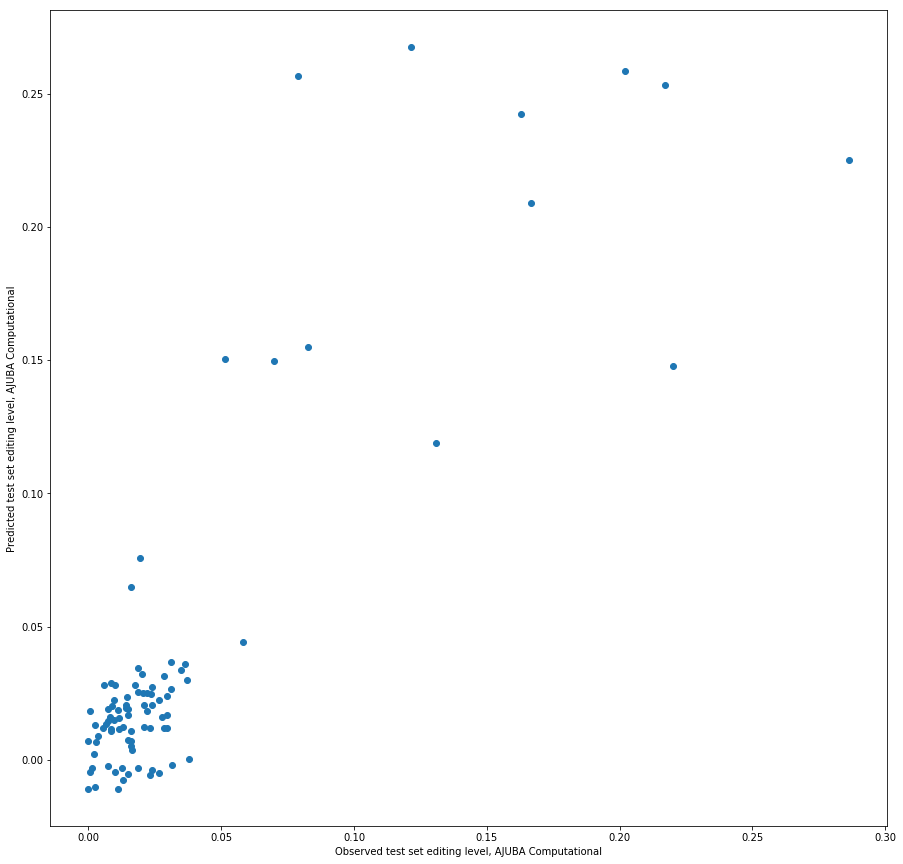

In [20]:
#plot the test set predictions 

matplotlib.rcParams['figure.figsize'] = [15, 15]
test_y=list(test_y)
test_pred=list(test_pred)
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(test_y,test_pred,'o')
plt.xlabel("Observed test set editing level, AJUBA Computational")
plt.ylabel("Predicted test set editing level, AJUBA Computational")
plt.show()

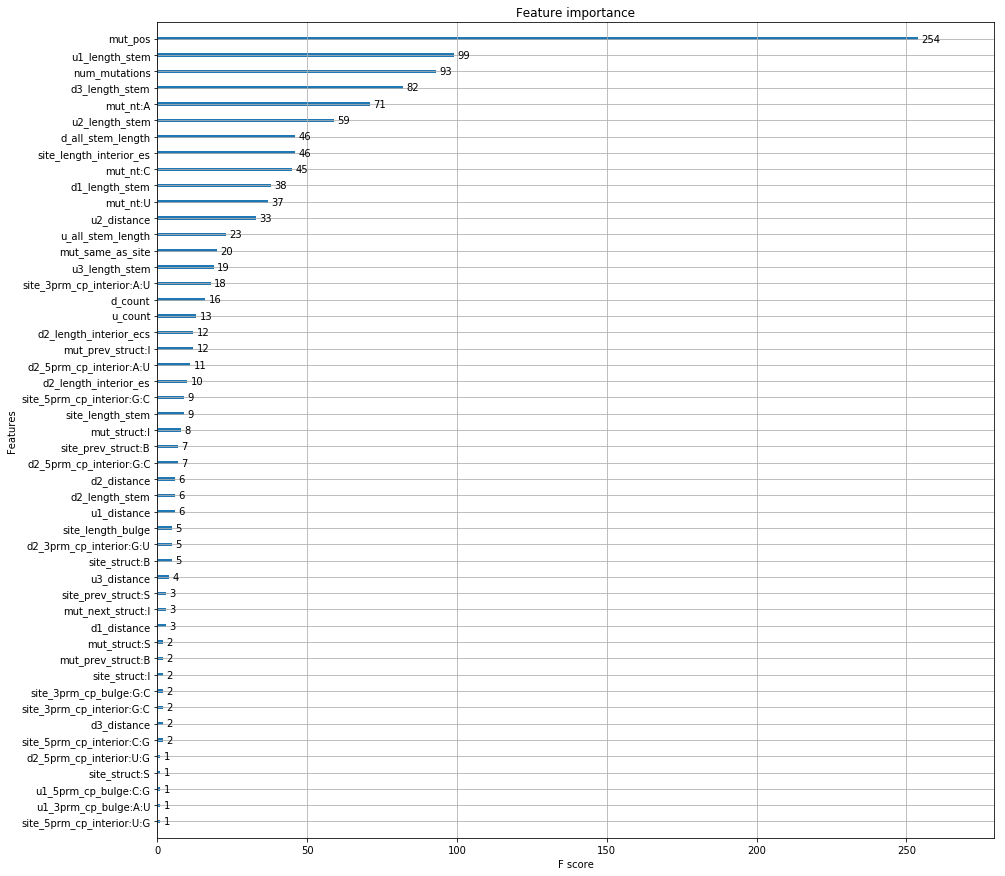

In [21]:
xgboost.plot_importance(bst)

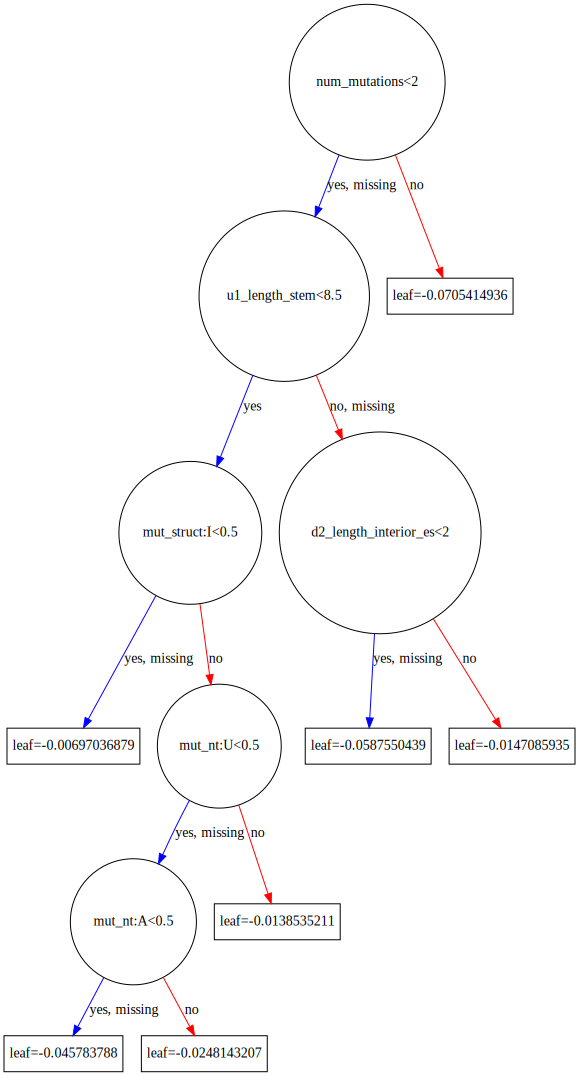

In [22]:
xgboost.to_graphviz(bst, num_trees=2)


In [23]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)


In [24]:
shap_values.shape

(89, 66)

In [25]:
# visualize prediction for isoform with the highest editing level 
max_index=test_y.index(max(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_index,:], test_X.iloc[max_index,:])

In [26]:
# visualize prediction for isoform with the lowest editing level 
min_index=test_y.index(min(test_y))
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[min_index,:], test_X.iloc[min_index,:])

In [27]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

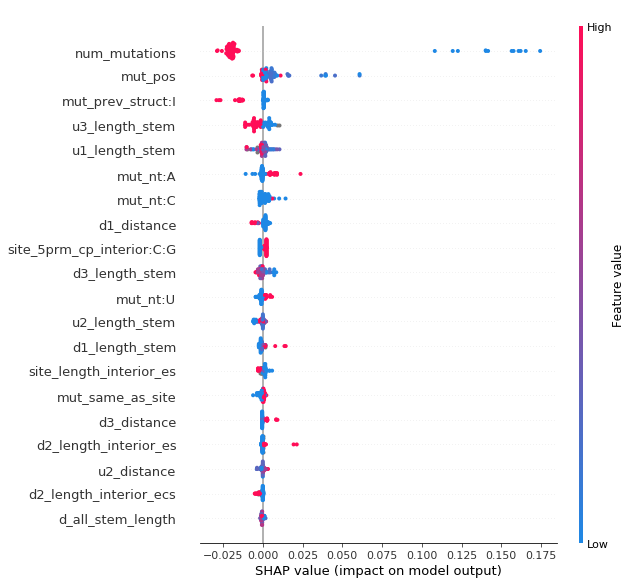

In [28]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


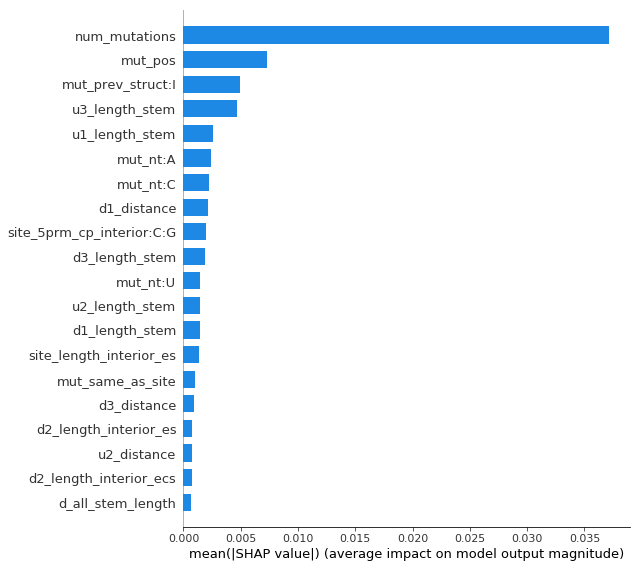

In [29]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [30]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)

In [31]:
shap_interaction_values.shape

(89, 66, 66)

In [32]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [33]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [34]:
enable_plotly_in_cell()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
tr=[trace]
iplot(tr,show_link=False)

## Computational Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [35]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

In [36]:
import feature_subsets 

In [37]:
print(feature_subsets.mut)
shap_contribs_subgroup(shap_values,feature_subsets.mut)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


0.7050508

In [38]:
print(feature_subsets.site)
shap_contribs_subgroup(shap_values,feature_subsets.site)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.052869752

In [39]:
print(feature_subsets.u)
shap_contribs_subgroup(shap_values,feature_subsets.u)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*']


0.12903252

In [40]:
print(feature_subsets.d)
shap_contribs_subgroup(shap_values,feature_subsets.d)

['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_interior*', 'd2_3prm_cp_interior*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_interior_es*', 'd3_length_interior_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_interior*', 'd3_3prm_cp_interior*']


0.12271571

In [41]:
print(feature_subsets.u_d)
shap_contribs_subgroup(shap_values,feature_subsets.u_d)

['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_interior_es*', 'u3_length_interior_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_interior*', 'u3_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge

0.25174823

In [42]:
print(feature_subsets.mut_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_site)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*']


0.7579205

In [43]:
print(feature_subsets.no_up)
shap_contribs_subgroup(shap_values,feature_subsets.no_up)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_interior_es*', 'd1_length_interior_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_interior*', 'd1_3prm_cp_interior*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_interior_es*', 'd2_length_interior_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_

0.8806363

In [44]:
print(feature_subsets.no_down)
shap_contribs_subgroup(shap_values,feature_subsets.no_down)

['num_mutations*', 'mut_exist*', 'mut_type*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_

0.886953

In [45]:
print(feature_subsets.site_struct)
shap_contribs_subgroup(shap_values,feature_subsets.site_struct)

['site_struct', 'site_length', 'site_length_interior_es', 'site_length_interior_ecs', 'site_3prm_cp_interior']


0.04024974

In [46]:
print(feature_subsets.site_seq)
shap_contribs_subgroup(shap_values,feature_subsets.site_seq)

['site_prev_nt*', 'site_next_nt*']


0.0

In [47]:
print(feature_subsets.mut_seq)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq)

['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


0.623065

In [48]:
print(feature_subsets.mut_seq_site)
shap_contribs_subgroup(shap_values,feature_subsets.mut_seq_site)

['site_prev_nt', 'site_next_nt', 'num_mutations', 'mut_pos', 'mut_site_dist', 'mut_ref_nt, mut_nt']


0.5469763

In [49]:
print(feature_subsets.no_mut)
shap_contribs_subgroup(shap_values,feature_subsets.no_mut)

['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_interior_es*', 'site_length_interior_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_interior*', 'site_3prm_cp_interior*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_interior_es*', 'u1_length_interior_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_interior*', 'u1_3prm_cp_interior*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_interior_es*', 'u2_length_interior_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_interior*', 'u2_3prm_cp_interior*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulg

0.304618